In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None).squeeze()
#x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)



all_input = []
all_output=[]
all_x=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_x.append(torch.tensor(inputData))
    all_input.append(torch.tensor(input_modes))
    all_output.append(torch.tensor(outputData))
    print(val)
    print(np.max(outputData))
#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
15
320.459
16
297.968
17
317.709
18
297.346
19
312.492


In [3]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=all_x[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
for i in range(len(meshes)):

    X=all_input[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)

In [4]:
new_labels = x_labels.copy()
for i,l in enumerate(new_labels):
    new_labels[i] = str(l)+"_one_over"

In [5]:
x_labels

0    CV_ventricles
1     k_ventricles
2            k_FEC
3         CV_atria
4          k_atria
5             k_BB
Name: 0, dtype: object

In [6]:
new_labels

0    CV_ventricles_one_over
1     k_ventricles_one_over
2            k_FEC_one_over
3         CV_atria_one_over
4          k_atria_one_over
5             k_BB_one_over
Name: 0, dtype: object

In [7]:
train_input_over=[]
test_input_over =[]
train_input_poly=[]
test_input_poly=[]
for i,inputs in enumerate(train_input):
    train_input_over.append(1/inputs)
    test_input_over.append(1/test_input[i])
    train_input_poly.append(torch.cat((train_input[i],train_input_over[i]),axis=1))
    test_input_poly.append(torch.cat((test_input[i],test_input_over[i]),axis=1))

In [8]:
y_train=train_output[0]
X_over_train=train_input_poly[0]
X_over_test=test_input_poly[0]

In [9]:
poly_degree=3

In [10]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor


pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=poly_degree, include_bias=False,interaction_only=False)),
    ('lasso', MultiTaskLassoCV(n_alphas=100,max_iter=10000))
])
estimator = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
                             

# fit to an order-3 polynomial data
model = estimator.fit(X_over_train, y_train)
lasso_coef=model.regressor_.named_steps['lasso'].coef_

In [11]:
y_train.mean(axis=0)

tensor([189.8976, 107.8595], dtype=torch.float64)

In [12]:
model.score(X_over_test,test_output[0])

0.9988651495729945

In [13]:
all_labels=x_labels.tolist()+new_labels.tolist()

In [14]:
np.array(all_labels)

array(['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria',
       'k_BB', 'CV_ventricles_one_over', 'k_ventricles_one_over',
       'k_FEC_one_over', 'CV_atria_one_over', 'k_atria_one_over',
       'k_BB_one_over'], dtype='<U22')

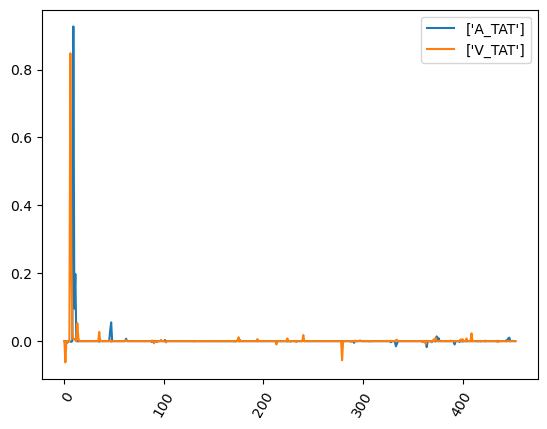

In [15]:
fig, ax = plt.subplots()
ax.plot((lasso_coef).T)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.legend(y_labels.values)

In [16]:
train_input_poly[0].shape

torch.Size([144, 12])

In [17]:
poly=PolynomialFeatures(degree=poly_degree, include_bias=False,interaction_only=False)

In [18]:
poly.fit_transform(train_input_poly[0]).shape

(144, 454)

In [19]:
si=torch.tensor(np.abs(lasso_coef)>0)

In [20]:
lasso_coef.shape

(2, 454)

In [21]:
poly.fit_transform(train_input_poly[0])[:,si[0]].shape

(144, 80)

In [22]:
torch.tensor(poly.fit_transform(train_input_poly[0])[:,si[0]]).shape

torch.Size([144, 80])

In [23]:
si

tensor([[False,  True, False,  True, False, False,  True,  True,  True,  True,
          True,  True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False,  True, False, False, False,
         False,  True, False, False, False,  True, False,  True, False, False,
         False, False, False, False, False, False,  True,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True, False,
          True, False, False,  True, False, False, False,  True, False, False,
         False,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [24]:
x_train=torch.tensor(poly.fit_transform(train_input_poly[0])[:,si[0]])

In [25]:
x_train.shape

torch.Size([144, 80])

In [26]:
x_train=torch.tensor(poly.fit_transform(train_input_poly[0])[:,si[0]])
y_train=train_output[0][:,[0]]
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=1000,poly_degree=poly_degree)

0


In [27]:
emulator.R2(torch.tensor(poly.fit_transform(test_input_poly[0])[:,si[0]]),test_output[0][:,[0]])

tensor([0.9998], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [28]:
x_train=train_input[0]
y_train=train_output[0]
emulator = GPE.ensemble(x_train,y_train,mean_func="structured",training_iter=1000,poly_degree=poly_degree)

0
1


In [29]:
emulator.models[1].state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-8.4030])),
             ('likelihood.noise_covar.noise_prior.a', tensor([0.1500])),
             ('likelihood.noise_covar.noise_prior.b', tensor([1.5000])),
             ('likelihood.noise_covar.noise_prior.sigma', tensor([0.1000])),
             ('likelihood.noise_covar.noise_prior.tails.loc', tensor([0.])),
             ('likelihood.noise_covar.noise_prior.tails.scale',
              tensor([0.1000])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(-3.2705)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[4.6359, 5.6038, 1.5395, 7.4574, 7.1567, 5.9192]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('cova

In [30]:
torch.cat((emulator.predict(test_input[0]),test_output[0]),axis=1)

tensor([[257.6586,  87.3245, 263.7830,  87.1896],
        [197.8721, 130.3032, 201.7220, 129.7760],
        [253.8395, 112.0249, 257.6020, 112.6300],
        [204.6781,  87.4301, 207.4580,  86.8735],
        [140.6632,  83.0144, 141.5290,  83.5694],
        [194.9357, 122.9037, 197.7120, 122.8320],
        [136.8635,  73.2688, 138.0200,  72.2409],
        [118.8432, 101.9987, 118.5300, 102.6590],
        [173.1242, 135.7300, 173.7970, 136.2880],
        [316.8914, 105.7337, 324.7620, 106.1740],
        [130.1176,  87.6598, 130.5700,  89.2496],
        [136.0461,  77.8253, 136.1380,  77.0862],
        [168.0446,  91.1371, 168.6040,  91.4379],
        [158.7002, 102.2727, 160.0540, 102.6060],
        [116.1177, 153.9228, 115.5580, 154.4850],
        [234.4124,  78.3039, 238.4700,  78.5169],
        [222.7231,  75.0472, 223.6830,  74.6867],
        [287.1786, 104.0175, 294.5890, 103.4690],
        [171.8320,  99.1654, 173.5580,  98.9606],
        [262.1829, 136.5708, 265.3950, 136.1370],


In [31]:
emulator.R2(test_input[0],test_output[0])

tensor([0.9969, 0.9992], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [32]:
y_train2=train_output[0]-torch.tensor(model.predict(X_over_train))

In [33]:
emulator = GPE.ensemble(train_input[0],y_train2,mean_func="zero",training_iter=1000,poly_degree=1)

0
1


In [34]:
1-(((emulator.predict(test_input[0])+torch.tensor(model.predict(X_over_test))-test_output[0])**2).mean(axis=0)/test_output[0].var(axis=0))

tensor([0.9994, 0.9985], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [35]:
1-(((torch.tensor(model.predict(X_over_test))-test_output[0])**2).mean(axis=0)/test_output[0].var(axis=0))

tensor([0.9993, 0.9985], dtype=torch.float64)

In [36]:
emulator = GPE.ensemble(train_input[0],train_output[0],mean_func="zero",training_iter=1000,poly_degree=1)

0
1


In [37]:
emulator.R2(test_input[0],test_output[0])

tensor([0.9994, 0.9981], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [39]:
nn=[20,40,60,80,100,120,140]
R2_p1=torch.zeros((len(nn),2,2))
reps=1
for j in range(len(meshes)):
    x_train=train_input[j]
    y_train=train_output[j]
    x_test=test_input[j]
    y_test=test_output[j]
    for i in range(reps):
        for k,n in enumerate(nn):

            b=np.random.choice(range(x_train.shape[0]),n,replace=False)
            emulator_s = GPE.ensemble(x_train[b],y_train[b],mean_func="structured",training_iter=1000,poly_degree=1)
            emulator = GPE.ensemble(x_train[b],y_train[b],mean_func="linear",training_iter=1000)

            R2_p1[k,:]+=torch.cat((emulator_s.R2(x_test,y_test)[None],emulator.R2(x_test,y_test)[None]),axis=0)/reps
            print(R2_p1[k,:])

0
1
0
1
tensor([[0.9851, 0.9740],
        [0.9277, 0.9262]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9953, 0.9767],
        [0.9962, 0.9667]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9991, 0.9983],
        [0.9982, 0.9957]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9967, 0.9985],
        [0.9984, 0.9981]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9995, 0.9983],
        [0.9980, 0.9975]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9998, 0.9974],
        [0.9993, 0.9971]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[0.9997, 0.9987],
        [0.9994, 0.9983]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[1.9255, 1.9263],
        [1.8314, 1.7876]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[1.9822, 1.9663],
        [1.9877, 1.9481]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[1.9967, 1.9922],
        [1.9964, 1.9876]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[1.9903, 1.9959],
        [1.9976, 1.9948]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[1.9988, 1.9966],
        [

1
0
1
tensor([[13.9677, 13.9424],
        [13.9732, 13.9115]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[13.9828, 13.9555],
        [13.9812, 13.9549]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[13.9877, 13.9615],
        [13.9884, 13.9657]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[13.9889, 13.9726],
        [13.9901, 13.9715]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.5073, 14.3225],
        [13.7418, 14.0953]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.8891, 14.8211],
        [14.9238, 14.7703]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.9581, 14.8849],
        [14.9591, 14.8818]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.9670, 14.9372],
        [14.9721, 14.9051]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.9821, 14.9527],
        [14.9789, 14.9493]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.9873, 14.9595],
        [14.9868, 14.9611]], grad_fn=<SliceBackward0>)
0
1
0
1
tensor([[14.9886, 14.9710],
        [14.9887, 14.9689]], grad_fn=<SliceBackward0>)
0

In [ ]:
lev=0
plt.plot(nn,R2_p1[:,0,lev].detach().numpy()/19)
plt.plot(nn,R2_p1[:,1,lev].detach().numpy()/19)
plt.legend(['structured','linear'])